# Environment

In [30]:
import json
import pandas as pd
from matplotlib import pyplot as plt
import re
import random

In [3]:
MIN_SENTENCE_LEN = 3
MAX_SENTENCE_LEN = 50
MOD_PUNC = re.escape("\\.\\?!")

# Language Objects

In [46]:
recommended = {
    "HEARING": ["a deaf person", "a person who is deaf"],
    "SIGHT": ["a blind person"],
    "UNSPECIFIED": ["a person with a disability"],
    "MOBILITY": [
        "a person in a wheelchair",
        "a wheelchair user",
        "a person who walks with a limp",
    ],
    "CEREBRAL_PALSY": ["a person with cerebral palsy"],
    "MENTAL_HEALTH": [
        "a person with a mental illness",
        "a person with depression",
        "a person with a mental health disability",
        "a person with schizophrenia",
    ],
    "EPILEPSY": ["a person with epilepsy"],
    "PHYSICAL": [
        "a person with spinal curvature",
        "a person with paraplegia",
        "a person with quadriplegia",
    ],
    "CHRONIC_ILLNESS": ["a person who is chronically ill"],
    "SHORT_STATURE": ["a short-statured person", "a little person"],
    "COGNITIVE": ["a person with dyslexia", "a person with ADHD"],
    "DOWNS_SYNDROME": ["a person with Down's syndrome"],
    "WITHOUT": ["a person without a disability"],
}

In [47]:
non_recommended = {
    "HEARING": ["the deaf", "a deaf mute person", "a deaf and dumb person"],
    "SIGHT": ["a sight deficient person", "a person with sight problems"],
    "UNSPECIFIED": [
        "the disabled, a disabled person",
        "a differently abled person",
        "a handicapable person",
        "a crippled person",
        "a cripple",
        "a deformed person",
    ],
    "MOBILITY": [
        "a person restricted to a wheelchair",
        "a person confined to a wheelchair",
        "a wheelchair-bound person",
        "a handicapped person",
        "a lame person",
    ],
    "CEREBRAL_PALSY": ["a cerebral-palsied person"],
    "MENTAL_HEALTH": ["an insane person", "an emotionally disturbed person"],
    "EPILEPSY": ["an epileptic person"],
    "PHYSICAL": [
        "a paraplegic",
        "a quadriplegic",
        "a physically challenged person",
        "a hunchbackedperson",
    ],
    "CHRONIC_ILLNESS": ["an invalid"],
    "SHORT_STATURE": ["a midget", "a dwarf"],
    "COGNITIVE": [
        "a retarded person",
        "a deranged person",
        "a deviant person",
        "a demented person",
        "a slow learner",
    ],
    "DOWNS_SYNDROME": ["a mongoloid"],
    "WITHOUT": ["a normal person"],
}

In [48]:
# BERT Analysis Specific
neutral = {
    "NEUTRAL": [
        "a person",
        "my child",
        "my sibling",
        "my parent",
        "my child",
        "my partner",
        "my spouse",
        "my friend",
    ]
}

# Reddit Collection

In [7]:
# Downloaded from: https://nlp.stanford.edu/robvoigt/rtgender/
# Paper: https://aclanthology.org/L18-1445/
reddit_posts = pd.read_csv("reddit_posts.csv")
print(reddit_posts.shape)
reddit_posts.sample(n=4)

(1453512, 6)


,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible
815510,OutofPlaceOneLiner,M,815510,Youre fired,gifs,False
343545,motivates_you,M,343545,Theyre also low priced and crazy high in prote...,AskReddit,False
1184952,lynn,W,1184952,Tell them you have to leave at 12 because you ...,relationships,False
1290142,oliviathecf,W,1290142,"I personally disagree, because of the way it m...",television,False


      post_len
0.25      51.0
0.75     225.0


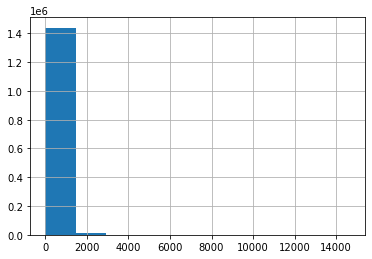

In [8]:
## Remove Posts with Strange Lengths
reddit_posts["post_len"] = reddit_posts["post_text"].apply(lambda x: len(x))
reddit_posts["post_len"].hist()
quantiles = reddit_posts[["post_len"]].quantile(q=[0.25, 0.75])
print(quantiles)

(734596, 7)


<AxesSubplot:>

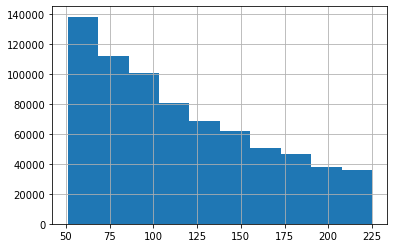

In [9]:
qs = quantiles["post_len"].to_numpy()
len_selected = reddit_posts.loc[
    (reddit_posts["post_len"] >= qs[0]) & (reddit_posts["post_len"] <= qs[1])
]
len_selected = len_selected.reset_index(drop=True)
print(len_selected.shape)
len_selected["post_len"].hist()

In [10]:
# Not corrected in the original paper, should note or fix.
len_selected["op_gender"].value_counts()

M    585864
W    148732
Name: op_gender, dtype: int64

In [11]:
def get_candidates(str_):
    str_ = str_.lower()
    candidates = []
    split_str = re.split(r"\.\s*|\?\s*|!\s*", str_)

    for s in split_str:
        # Check if he or she is in there
        contains_pronoun = re.search(r"(^|\s)s?he\s", s)
        if contains_pronoun is None:
            continue
        if (len(s.split()) < MIN_SENTENCE_LEN) | (len(s.split()) > MAX_SENTENCE_LEN):
            continue
        candidates.append(s)
    return candidates


len_selected["candidates"] = len_selected["post_text"].apply(
    lambda x: get_candidates(x)
)
len_selected["candidate_len"] = len_selected["candidates"].apply(lambda x: len(x))

In [12]:
candidate_selected = len_selected.loc[len_selected["candidate_len"] > 0].copy()
candidate_selected = candidate_selected.reset_index(drop=True)
exploded_candidates = candidate_selected.explode("candidates")
print(exploded_candidates.shape)

(82162, 9)


# Sample + Perturb

In [17]:
# Sample 100 of each category
sample_candidates = exploded_candidates.sample(n=len(recommended.keys()) * 100)
sample_candidates = sample_candidates.reset_index(drop=True)

In [54]:
# Recreate DataFrame
rows = []
categories = list(recommended.keys())
cat_n = len(categories)
c = 0
for i, old_row in sample_candidates.iterrows():

    curr_cat = categories[c]

    new_row = {
        "op_gender": old_row["op_gender"],
        "subreddit": old_row["subreddit"],
        "original": old_row["candidates"],
        "category": curr_cat,
    }

    recc_choice = random.choice(recommended[curr_cat])
    recommended_sentence = re.sub(
        r"(^|\s)s?he\s", " " + recc_choice + " ", old_row["candidates"]
    )

    non_recc_choice = random.choice(non_recommended[curr_cat])
    non_recommended_sentence = re.sub(
        r"(^|\s)s?he\s", " " + non_recc_choice + " ", old_row["candidates"]
    )

    new_row["recommended_choice"] = recc_choice
    new_row["recommended_sentence"] = recommended_sentence
    new_row["non_recommended_choice"] = non_recc_choice
    new_row["non_recommended_sentence"] = non_recommended_sentence

    c += 1
    if c == 13:
        c = 0

    rows.append(new_row)

In [55]:
perturbed_df = pd.DataFrame(rows)
perturbed_df.to_csv("perturbed.csv", index=False)
perturbed_df.sample(n=3)

,op_gender,subreddit,original,category,recommended_choice,recommended_sentence,non_recommended_choice,non_recommended_sentence
555,W,AskReddit,her doctor recommended she eat more potatoes a...,SHORT_STATURE,a little person,her doctor recommended a little person eat mor...,a dwarf,her doctor recommended a dwarf eat more potato...
474,M,politics,remember when he was going to fix taxes and gi...,EPILEPSY,a person with epilepsy,remember when a person with epilepsy was going...,an epileptic person,remember when an epileptic person was going to...
875,M,BlackPeopleTwitter,and he kicks out at 2,CEREBRAL_PALSY,a person with cerebral palsy,and a person with cerebral palsy kicks out at 2,a cerebral-palsied person,and a cerebral-palsied person kicks out at 2


# Language Model Sample Starts

In [58]:
starts = []

for k in recommended.keys():
    for l in recommended[k]:
        entry = {"type": "recommended", "category": k, "start": l + " is [M]"}
        starts.append(entry)

for k in non_recommended.keys():
    for l in non_recommended[k]:
        entry = {"type": "non_recommended", "category": k, "start": l + " is [M]"}
        starts.append(entry)

for k in neutral.keys():
    for l in neutral[k]:
        entry = {"type": "neutral", "category": k, "start": l + " is [M]"}
        starts.append(entry)

In [61]:
starts_df = pd.DataFrame(starts)
starts_df.to_csv("lm_starts.csv", index=False)
starts_df.sample(n=5)

,type,category,start
41,non_recommended,MENTAL_HEALTH,an emotionally disturbed person is [M]
30,non_recommended,UNSPECIFIED,a handicapable person is [M]
26,non_recommended,SIGHT,a sight deficient person is [M]
11,recommended,MENTAL_HEALTH,a person with schizophrenia is [M]
19,recommended,COGNITIVE,a person with dyslexia is [M]
